In [4]:
import torch
import torch.nn.functional as F
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# --- Helper functions (provided in the prompt) ---
def _jeffrey_divergence(
    u: torch.Tensor, v: torch.Tensor, eps: float = 1e-8
) -> torch.Tensor:
    u = u + eps
    v = v + eps

    # KL(u‖v)
    kl_uv = torch.sum(u * (torch.log(u) - torch.log(v)))
    # KL(v‖u)
    kl_vu = torch.sum(v * (torch.log(v) - torch.log(u)))

    return 0.5 * (kl_uv + kl_vu)


def _jeffrey_similarity(vectors: torch.Tensor) -> torch.Tensor:
    k = vectors.size(0)
    if k < 2:
        return torch.zeros((), device=vectors.device)

    sims = []
    for i, j in combinations(range(k), r=2):
        d_j = _jeffrey_divergence(vectors[i], vectors[j])
        sims.append(torch.exp(-d_j))

    if not sims: # handles k < 2 after loop
        return torch.zeros((), device=vectors.device)
    return torch.stack(sims).mean()


def prototype_diversity_loss(
    feature_map: torch.Tensor,
    labels: torch.Tensor,
    prototypes: torch.Tensor,
    proto_classes: torch.Tensor,
    lambda_j: float = 1.0, # Set to 1 for direct comparison
    temperature: float = 1.0,
) -> torch.Tensor:
    if lambda_j == 0.0:
        return torch.zeros((), device=feature_map.device)

    bsz, d, h, w = feature_map.shape
    # Ensure proto_classes is long tensor for max() and indexing
    proto_classes = proto_classes.long()
    max_class_idx = proto_classes.max().item() if proto_classes.numel() > 0 else -1
    n_classes = int(max_class_idx + 1)
    
    if n_classes == 0: # No classes present
        return torch.zeros((), device=feature_map.device)


    # Move channels last for easier indexing.
    feat_flat = feature_map.permute(0, 2, 3, 1).reshape(bsz, h * w, d) # (B, N, D)
    lab_flat = labels.view(bsz, -1) # (B, N)

    loss_acc = 0.0
    actual_classes_processed = 0 # Count classes that contribute to loss
    for b in range(bsz):
        for c in range(n_classes):
            # mask for class *c* in sample *b*
            idx = (lab_flat[b] == c).nonzero(as_tuple=True)[0]
            if idx.numel() == 0:
                continue # class absent in this sample

            prot_idx = (proto_classes == c).nonzero(as_tuple=True)[0]
            if prot_idx.numel() < 2:
                continue # Need at least two prototypes to compare.

            actual_classes_processed +=1
            # Feature vectors for class‑c pixels
            z_c = feat_flat[b, idx] # (N_c, D)

            # Build probability vectors v(Z, p) for every prototype p∈P_c
            v_list = []
            for p_id in prot_idx:
                p = prototypes[p_id] # (D,)
                # Euclidean distances to all selected pixels
                dist = torch.norm(z_c - p.unsqueeze(0), dim=1) / temperature # (N_c,)
                v = F.softmax(dist, dim=0) # (N_c,)
                v_list.append(v)

            v_stack = torch.stack(v_list) # (K, N_c)
            sj = _jeffrey_similarity(v_stack)
            loss_acc = loss_acc + sj
    
    if actual_classes_processed == 0: # No valid class pairs found
        return torch.zeros((), device=feature_map.device)
        
    loss = loss_acc / actual_classes_processed # Average over classes that contributed
    return loss * lambda_j


def activation_overlap_loss(
    similarity_maps: torch.Tensor,
    proto_classes: torch.Tensor,
    lambda_div: float = 1.0, # Set to 1 for direct comparison
    eps: float = 1e-6,
) -> torch.Tensor:
    if lambda_div == 0.0:
        return torch.zeros((), device=similarity_maps.device)

    # Keep only positive evidence.
    acts = similarity_maps.clamp(min=0) # (B, P, H, W)
    B, P, H, W = acts.shape
    S = H * W
    acts = acts.view(B, P, S) # (B, P, S)

    # L1‑normalise each activation map so that it sums to 1.
    acts = acts / (acts.sum(dim=2, keepdim=True) + eps)
    
    # Ensure proto_classes is long tensor for max() and indexing
    proto_classes = proto_classes.long()
    max_class_idx = proto_classes.max().item() if proto_classes.numel() > 0 else -1
    n_classes = int(max_class_idx + 1)

    if n_classes == 0: # No classes present
        return torch.zeros((), device=similarity_maps.device)

    loss_acc = 0.0
    actual_classes_processed = 0 # Count classes that contribute to loss
    for c in range(n_classes):
        prot_idx = (proto_classes == c).nonzero(as_tuple=True)[0]
        k = prot_idx.numel()
        if k < 2:
            continue
        
        actual_classes_processed +=1
        a_c = acts[:, prot_idx] # (B, k, S)
        # Pairwise inner products <Â_i, Â_j>
        sim = torch.einsum("bks,bls->bkl", a_c, a_c) # (B, k, k)
        
        if k > 1: # Ensure there are pairs to select
            # Upper‑triangular without diagonal
            # Correct way to get indices for PyTorch
            row_indices, col_indices = torch.triu_indices(k, k, offset=1)
            if row_indices.numel() > 0: # If there are any upper-triangular pairs
                 sim_pairs = sim[:, row_indices, col_indices]
                 loss_acc += sim_pairs.mean() # Mean over pairs for this class, and over batch

    if actual_classes_processed == 0 : # No valid class pairs found
         return torch.zeros((), device=similarity_maps.device)

    return (loss_acc / actual_classes_processed) * lambda_div # Average over classes that contributed

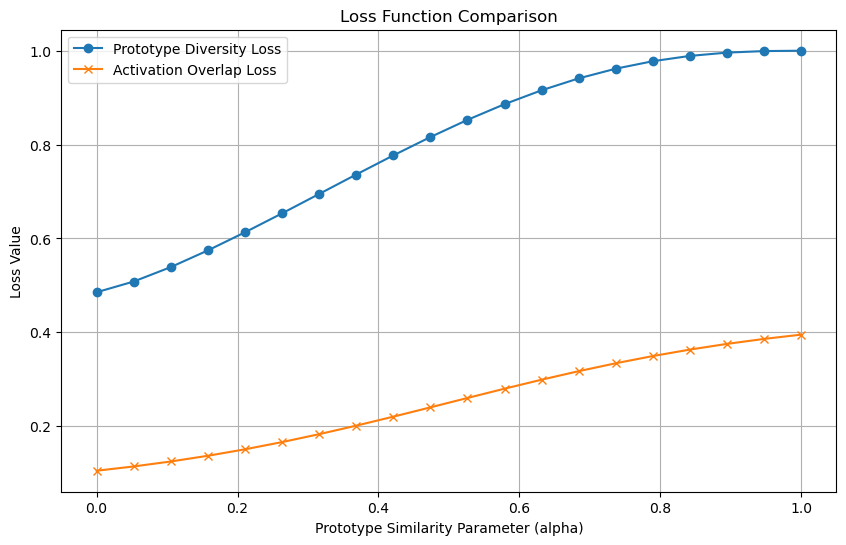

In [11]:
# --- Shared Parameters ---
B, D_feat, H_img, W_img = 1, 2, 1, 4 # D_feat for feature dim, H_img, W_img for image dims
P_protos = 2 # Number of prototypes
proto_classes_tensor = torch.tensor([0, 0], dtype=torch.long) # Both prototypes belong to class 0
labels_tensor = torch.zeros((B, H_img, W_img), dtype=torch.long) # All pixels class 0

# Fixed feature map (designed for distinct initial prototypes)
# Pixels 0,1 are "like" [1,0], pixels 2,3 are "like" [0,1]
feature_map_pixels = torch.tensor([[[1.1, 0.1], [0.9, -0.1], [0.1, 1.1], [-0.1, 0.9]]], dtype=torch.float) # (B, W_img, D_feat)
feature_map_tensor = feature_map_pixels.permute(0,2,1).unsqueeze(2) # (B, D_feat, 1, W_img) -> (B, D_feat, H_img, W_img)

# Define base prototypes
proto_0_fixed = torch.tensor([1.0, 0.0], dtype=torch.float)
proto_1_distinct = torch.tensor([0.0, 1.0], dtype=torch.float)

# Alpha values for interpolation
alpha_values = np.linspace(0, 1, 20)
pdl_results = []
aol_results = []

# --- Run Experiment ---
for alpha in alpha_values:
    # Interpolate prototype 1
    proto_1_current = (1 - alpha) * proto_1_distinct + alpha * proto_0_fixed
    current_prototypes = torch.stack([proto_0_fixed, proto_1_current])

    # 1. Calculate Prototype Diversity Loss
    pdl = prototype_diversity_loss(feature_map_tensor, labels_tensor, current_prototypes, proto_classes_tensor)
    pdl_results.append(pdl.item())

    # 2. Calculate Activation Overlap Loss
    #   a. Create Similarity Maps: sim = exp(-dist^2)
    pixels_flat = feature_map_tensor.permute(0, 2, 3, 1).reshape(B * H_img * W_img, D_feat)
    sim_maps_list = []
    for i in range(P_protos):
        dist_sq = torch.norm(pixels_flat - current_prototypes[i].unsqueeze(0), dim=1).pow(2)
        sim_scores = torch.exp(-dist_sq) # Using sigma_sq_implicit = 0.5 by not dividing dist_sq
        sim_maps_list.append(sim_scores.view(B, H_img, W_img))
    similarity_maps = torch.stack(sim_maps_list, dim=1)

    #   b. Calculate AOL
    aol = activation_overlap_loss(similarity_maps, proto_classes_tensor)
    aol_results.append(aol.item())

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, pdl_results, label='Prototype Diversity Loss', marker='o')
plt.plot(alpha_values, aol_results, label='Activation Overlap Loss', marker='x')

plt.xlabel('Prototype Similarity Parameter (alpha)')
plt.ylabel('Loss Value')
plt.title('Loss Function Comparison')
plt.legend()
plt.grid(True)
plt.show()